# Sampler

> Generate random sample locations.

In [110]:
#| default_exp sampler

In [111]:
#| hide
from nbdev.showdoc import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
#| export
import rasterio
import fastcore.all as fc
import geopandas as gpd
import pandas as pd
import numpy as np

In [113]:
#| hide
from trufl.utils import gridder
import numpy as np
red, black = '#BF360C', '#263238'

In [114]:
#| exports
class Sampler:
    "Sample random location in `smp_areas`."
    def __init__(self, 
                 smp_areas:gpd.GeoDataFrame, # Geographical area to sample from.
                ) -> gpd.GeoDataFrame: # loc_id, geometry (Point or MultiPoint).
        fc.store_attr()
        
    @property
    def loc_ids(self):
        arr = self.smp_areas.reset_index().loc_id.values
        if len(arr) != len(np.unique(arr)):
            raise ValueError(f'{self.loc_id_col} column contains non-unique values.')
        else:
            return arr
        
    def sample(self, 
               n:np.ndarray, # Number of samples
               **kwargs
              ):
        mask = n == 0    
        pts_gseries = self.smp_areas[~mask].sample_points(n[~mask], **kwargs)
        gdf_pts = gpd.GeoDataFrame(geometry=pts_gseries, index=pts_gseries.index)
        gdf_pts.index.name = 'loc_id'
        return gdf_pts

How to use:

In [115]:
#|eval: false
fname_raster = './files/ground-truth-02-4326-simulated.tif'
gdf_grid = gridder(fname_raster, nrows=10, ncols=10)

sampler = Sampler(gdf_grid)
n = np.random.randint(0, high=10, size=len(gdf_grid), dtype=int)
gdf_samples = sampler.sample(n, method='uniform'); print(gdf_samples.head())

                                                 geometry
loc_id                                                   
0       MULTIPOINT (-1.21319 43.01176, -1.20744 43.005...
1       MULTIPOINT (-1.22320 43.03429, -1.21657 43.051...
2       MULTIPOINT (-1.22229 43.09713, -1.21626 43.078...
3       MULTIPOINT (-1.22233 43.12831, -1.22226 43.101...
4       MULTIPOINT (-1.21914 43.16511, -1.21857 43.168...


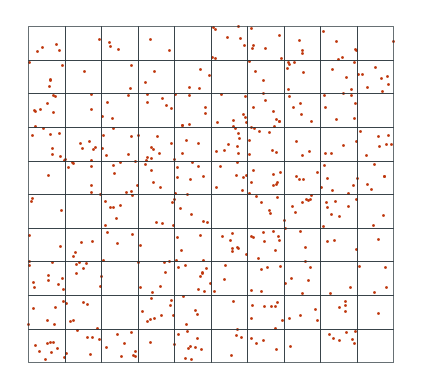

In [116]:
#|eval: false
ax = gdf_samples.plot(markersize=1, c=red)
gdf_grid.boundary.plot(ax=ax, color=black, lw=0.5)
ax.axis('off');

In [117]:
#|exports
def rank_to_sample(ranks:np.ndarray, # Ranks sorted by `loc_id`s
                   budget:int, # Total data collection budget available
                   min:int=0, # Minimum of samples to be collected per area of interest
                  policy:str="Weighted" # policy used form mapping ranks to number of samples
                  ) -> np.ndarray: # Number of samples per area of interest to be collected in the same order as ranks
    "Map ranks to number of samples to be collected"
    if policy == "Weighted":
        weights = 1/ranks
        normalized_weights = np.array(weights) / np.sum(weights)
        allocation = np.round(budget * normalized_weights).astype(int)
        return np.where(allocation < min, min, allocation)
    
    elif policy == "Quantiles":
        # 4. Sampling policy (based on 4 quantiles of rank)
        n_quantile = len(ranks)/4
        sampling_policy = [int(budget*0.5/n_quantile), int(budget*0.3/n_quantile), int(budget*0.20/n_quantile), 0]

        # Calculate quantiles thresholds
        quantiles_thresholds = np.quantile(ranks, [0.25, 0.5, 0.75, 1.0])
        
        # Assign each rank to a quantile
        quantile_indices = np.digitize(ranks, quantiles_thresholds, right=True)
        
        # Map each quantile to its corresponding value in sampling_policy
        samples_per_quantile = np.array([sampling_policy[i] for i in quantile_indices])
        
        # Ensure minimum samples collected per area
        samples_per_quantile = np.where(samples_per_quantile < min, min, samples_per_quantile)
        
        return samples_per_quantile
    else:
        raise ValueError(f'Policy {policy} not implemented.')

In [118]:
#| hide
import nbdev; nbdev.nbdev_export()